# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [6]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

### Perform some basic filtering

In [7]:
adata = sc.read(data_path + 'interferon.raw.h5ad')

In [8]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

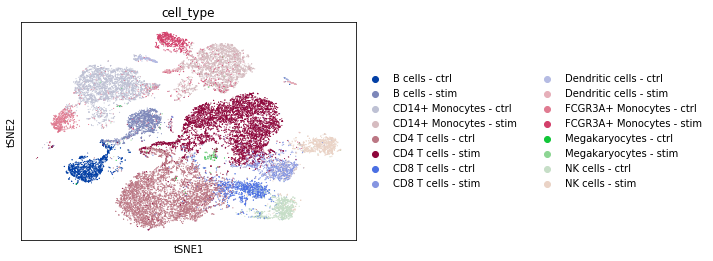

In [9]:
sc.pl.tsne(adata, color='cell_type')

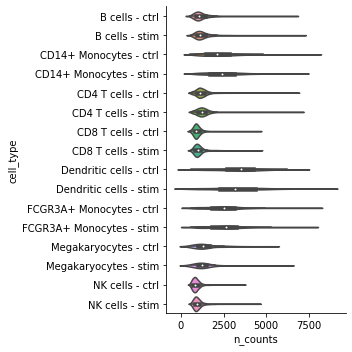

In [10]:
sns.catplot(x='n_counts', y='cell_type', data=adata.obs, kind='violin')

In [11]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1884


### Cell type markers

In [31]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [32]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [33]:
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_moments(ct)
    estimator.compute_estimated_moments(ct)
    estimator.compute_params(ct)
    estimator.compute_observed_moments('-' + ct)
    estimator.compute_estimated_moments('-' + ct)
    estimator.compute_params('-' + ct)
    estimator.hypothesis_test_1d('-' + ct, ct)
    upreg_stats, upreg_genes = estimator.get_increased_exp_genes('-' + ct, ct, num_genes=25)
    
    print(upreg_genes)

Calculating stats for CD14+ Monocytes
['C15orf48' 'IL8' 'SOD2' 'S100A11' 'CD63' 'TYROBP' 'S100A8' 'GAPDH'
 'FCER1G' 'S100A4' 'LGALS1' 'LGALS3' 'ANXA5' 'EMP3' 'LYZ' 'S100A9' 'ANXA2'
 'TYMP' 'CD14' 'MARCKSL1' 'HLA-DRB1' 'NFKBIA' 'GPX1' 'CTSB' 'CSTB']
Calculating stats for CD4 T cells
['LTB' 'CCR7' 'CD3D' 'SELL' 'RGCC' 'LEPROTL1' 'IL7R' 'OCIAD2' 'ITM2A'
 'CD7' 'TRAT1' 'CREM' 'PIK3IP1' 'LCK' 'CD3E' 'CD2' 'TSC22D3' 'GIMAP5'
 'C6orf48' 'GIMAP4' 'CD52' 'LAT' 'SPOCK2' 'LEF1' 'AES']
Calculating stats for Dendritic cells
['HLA-DRB1' 'TXN' 'HLA-DPB1' 'HLA-DPA1' 'LYZ' 'C15orf48' 'HLA-DQA1' 'CST3'
 'GAPDH' 'HLA-DQB1' 'ANXA2' 'CCR7' 'LGALS1' 'GPR183' 'EMP3' 'IL8'
 'MARCKSL1' 'IDO1' 'CD63' 'S100A11' 'NFKBIA' 'HLA-DMA' 'BIRC3' 'SERPINB1'
 'INSIG1']
Calculating stats for NK cells
['GNLY' 'CCL5' 'NKG7' 'GZMB' 'APOBEC3G' 'CST7' 'FGFBP2' 'CLIC3' 'CD7'
 'RARRES3' 'PRF1' 'GZMA' 'KLRD1' 'CTSW' 'CCL4' 'CHST12' 'GZMH' 'CD247'
 'APMAP' 'HOPX' 'TNFRSF18' 'CLEC2B' 'KLRC1' 'SEPT7' 'ALOX5AP']
Calculating stats for 

### Effect of interferon stimulation

In [ ]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [ ]:
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_moments(ct)
    estimator.compute_estimated_moments(ct)
    estimator.compute_params(ct)


In [14]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [15]:
estimator.compute_observed_moments('CD4 T cells')
estimator.compute_estimated_moments('CD4 T cells')
estimator.compute_params('CD4 T cells')

In [16]:
estimator.compute_observed_moments('-CD4 T cells')
estimator.compute_estimated_moments('-CD4 T cells')
estimator.compute_params('-CD4 T cells')

In [17]:
%%time
estimator.hypothesis_test_1d('-CD4 T cells', 'CD4 T cells')

CPU times: user 22 s, sys: 4.57 s, total: 26.6 s
Wall time: 38.6 s


In [25]:
upreg_stats, upreg_genes = estimator.get_increased_exp_genes('-CD4 T cells', 'CD4 T cells', num_genes=25)
upvar_stats, upvar_genes = estimator.get_increased_var_genes('-CD4 T cells', 'CD4 T cells', num_genes=25)

In [28]:
np.log(np.nanmin(upvar_stats))

2.5841053912143295

In [26]:
upvar_stats.min()

nan

In [29]:
np.log(upreg_stats.min())

1.002976691550173

(-20, 20)

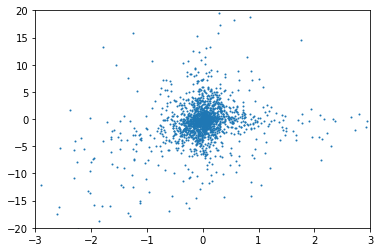

In [30]:
plt.scatter(
    estimator.hypothesis_test_result_1d[frozenset(['-CD4 T cells', 'CD4 T cells'])]['de_diff'],
    estimator.hypothesis_test_result_1d[frozenset(['-CD4 T cells', 'CD4 T cells'])]['dv_diff'],
    s=1
)

plt.xlim(-3, 3)
plt.ylim(-20, 20)

In [ ]:
plt.

In [265]:
upreg_genes

Index(['ITM2A', 'CD7', 'TRAT1', 'PIK3IP1', 'CD2', 'TSC22D3', 'CD52', 'LEF1',
       'PASK', 'RHOH', 'CD3G', 'KLF2', 'CD27', 'CLEC2D', 'CACYBP', 'IL32',
       'HBG1', 'SNHG8', 'FYN', 'SNHG7', 'NELL2', 'NR3C1', 'PIM1', 'PTPRCAP',
       'TSHZ2'],
      dtype='object', name='index')

In [266]:
inc_var_genes

Index(['SETBP1', 'ADORA3', 'RP11-164H13.1', 'EDN1', 'CSRP2', 'KRT81', 'KLRC2',
       'HLA-DOB', 'CLEC4C', 'CATSPER1', 'COL19A1', 'MS4A12', 'SCT', 'C1QB',
       'PTGDS', 'CX3CR1', 'E2F5', 'IDO2', 'PNOC', 'DNASE1L3', 'KLK1', 'NCR1',
       'PTX3', 'NME8', 'APBB2'],
      dtype='object', name='index')

In [104]:
raw_mean = estimator.observed_moments['CD4 T cells']['first']
raw_var = estimator.observed_moments['CD4 T cells']['second'] - raw_mean**2
raw_fano_factor = raw_var/raw_mean
raw_cv = np.sqrt(raw_var)/raw_mean

In [105]:
mean =estimator.estimated_central_moments['CD4 T cells']['first']
var = estimator.estimated_central_moments['CD4 T cells']['second']
fano_factor = var/mean
cv = var/mean**2



(0, 50)

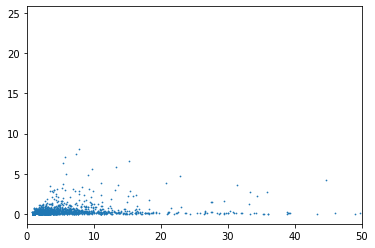

In [132]:
plt.scatter(fano_factor, mean, s=0.5)
plt.xlim(0, 50)



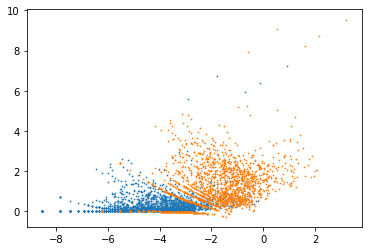

In [20]:
plt.scatter(np.log(raw_mean), np.log(raw_fano_factor), s=0.5)
plt.scatter(np.log(mean), np.log(fano_factor),s=0.5)



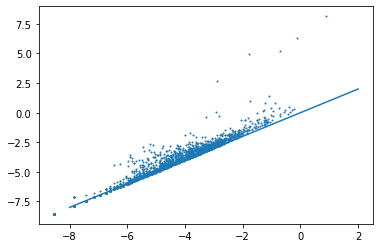

In [295]:
plt.scatter(np.log(raw_mean), np.log(raw_var), s=1)
plt.plot([-8, 2], [-8, 2])

In [276]:
mean =estimator.estimated_central_moments['CD4 T cells']['first']
var = estimator.estimated_central_moments['CD4 T cells']['second']
fano_factor = var/mean
cv = np.sqrt(var)/mean

(0, 2.5)

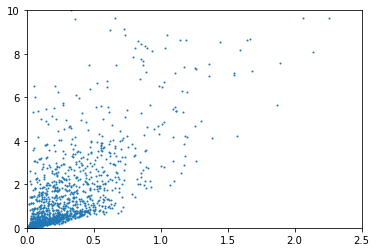

In [277]:
plt.scatter(mean, var,s=1)
plt.ylim(0, 10)
plt.xlim(0, 2.5)

(0, 2.5)

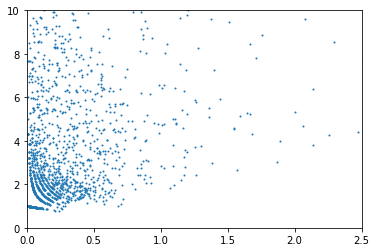

In [278]:
plt.scatter(mean, fano_factor,s=1)
plt.ylim(0, 10)
plt.xlim(0, 2.5)

(0, 2.5)

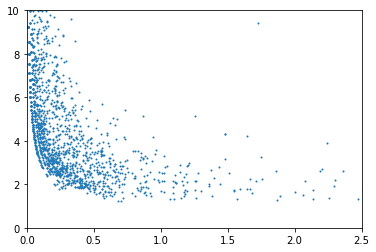

In [279]:
plt.scatter(mean, cv,s=1)
plt.ylim(0, 10)
plt.xlim(0, 2.5)

In [280]:
    np.isclose(
        estimator.observed_moments['CD4 T cells']['first'],
        estimator.observed_moments['CD4 T cells']['second']
        ).sum()

49

In [281]:
mask = np.isfinite(np.log(estimator.estimated_central_moments['CD4 T cells']['first'])) & \
    np.isfinite(np.log(estimator.estimated_central_moments['CD4 T cells']['second'])) & \
    ~np.isclose(
        estimator.observed_moments['CD4 T cells']['first'],
        estimator.observed_moments['CD4 T cells']['second'],
        rtol=1e-5
        )

In [282]:
mask.sum()

1947

In [283]:
stats.linregress(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first'])[mask],
    np.log(estimator.estimated_central_moments['CD4 T cells']['second'])[mask]
)

LinregressResult(slope=1.2773909564458263, intercept=1.7328783244294268, rvalue=0.8923104992372801, pvalue=0.0, stderr=0.014653147205705932)

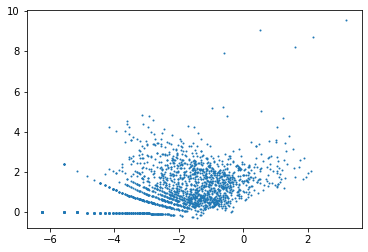

In [284]:
plt.scatter(np.log(mean[mask]), np.log(fano_factor[mask]),s=1)
#plt.plot([-6, 2], [6, -2])


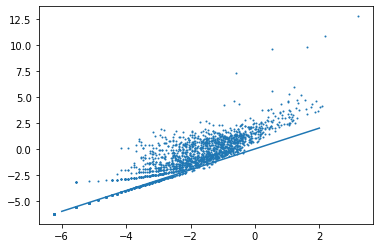

In [285]:
plt.scatter(np.log(mean), np.log(var),s=1)
plt.plot([-6, 2], [-6, 2])


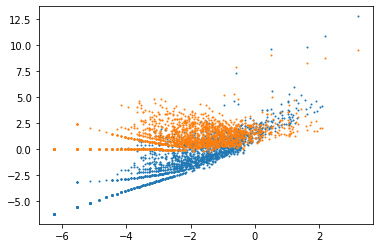

In [286]:
plt.scatter(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first']),
    np.log(estimator.estimated_central_moments['CD4 T cells']['second']),
    s=1
)
plt.scatter(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first']),
    np.log(estimator.estimated_central_moments['CD4 T cells']['second'])-np.log(estimator.estimated_central_moments['CD4 T cells']['first']),
    s=1
)
#plt.plot([-6, 2], [6, -2])
#plt.plot([-6, 2], [-6, 2])
# plt.ylim(0, 5)
# plt.xlim(0, 1.5)


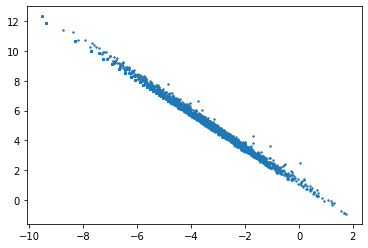

In [290]:
plt.scatter(
    estimator.parameters['CD4 T cells']['mean'],
    np.sqrt(estimator.parameters['CD4 T cells']['var']) - estimator.parameters['CD4 T cells']['mean'] ,
    s=2,
)
#plt.ylim(-0.1, 1)
#plt.plot(np.arange(-8, 4, 0.1), np.arange(-8, 4, 0.1)*res[0] + res[1])

(-0.1, 0.1)

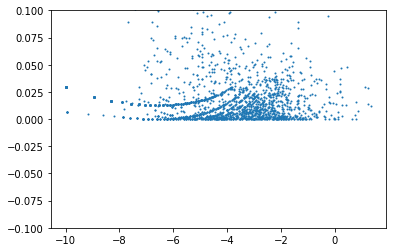

In [160]:
plt.scatter(
    estimator.parameters['CD4 T cells']['mean'],
    estimator.parameters['CD4 T cells']['resid_var'],
    s=1,
)
plt.ylim(-0.1, 0.1)
#plt.plot(np.arange(-8, 4, 0.1), np.arange(-8, 4, 0.1)*res[0] + res[1])

(0, 0.1)

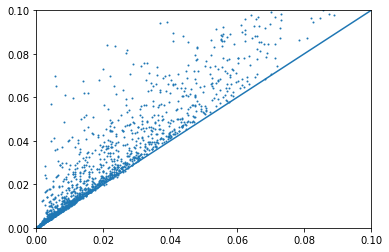

In [60]:
plt.scatter(
    estimator.observed_moments['CD4 T cells']['first'],
    estimator.observed_moments['CD4 T cells']['second'] - estimator.observed_moments['CD4 T cells']['first']**2,
    s=1,
)
plt.plot([0, 1], [0, 1])

plt.ylim(0, 0.1)
plt.xlim(0, 0.1)


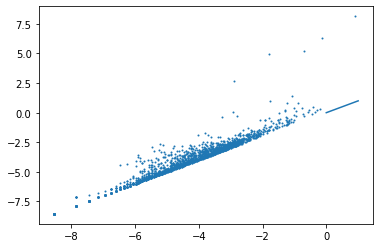

In [19]:
plt.scatter(
    np.log(estimator.observed_moments['CD4 T cells']['first']),
    np.log(estimator.observed_moments['CD4 T cells']['second'] - estimator.observed_moments['CD4 T cells']['first']**2),
    s=1,
)
plt.plot([0, 1], [0, 1])

# plt.ylim(0, 0.1)
# plt.xlim(0, 0.1)


In [217]:
mask = np.isfinite(np.log(estimator.estimated_central_moments['CD4 T cells']['first'])) & \
    np.isfinite(np.log(estimator.estimated_central_moments['CD4 T cells']['second']))

(0, 3)

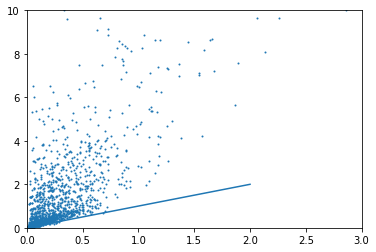

In [23]:
plt.scatter(
    estimator.estimated_central_moments['CD4 T cells']['first'],
    estimator.estimated_central_moments['CD4 T cells']['second'],
    s=1
)
plt.plot([0, 2], [0, 2])


plt.ylim(0, 10)
plt.xlim(0, 3)


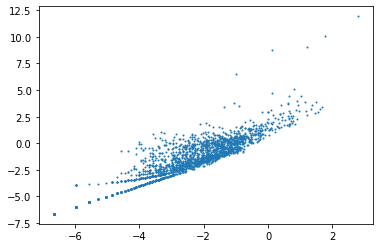

In [152]:
plt.scatter(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first']),
    np.log(estimator.estimated_central_moments['CD4 T cells']['second']),
    s=1
)
# plt.ylim(0, 5)
# plt.xlim(0, 1.5)


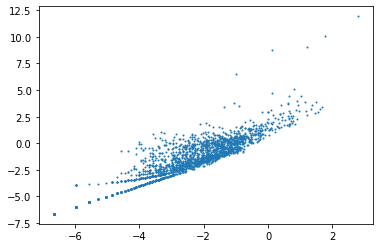

In [137]:
plt.scatter(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first']),
    np.log(estimator.estimated_central_moments['CD4 T cells']['second']),
    s=1
)
# plt.scatter(
#     np.log(estimator.observed_moments['CD4 T cells']['first']),
#     np.log(estimator.observed_moments['CD4 T cells']['second'] - estimator.observed_moments['CD4 T cells']['first']**2),
#     s=.1,
# )
#plt.plot([-6, 2], [-4.5, 3.5])


# plt.ylim(0, 10)
# plt.xlim(0, 2)


(0, 5)

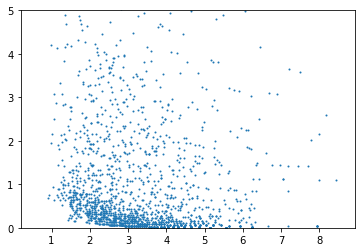

In [64]:
plt.scatter(
    lognormal_params[1, :],
    estimator.estimated_central_moments['CD4 T cells']['second'],
    s=1
    )
plt.ylim(0, 5)

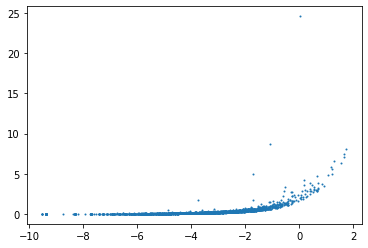

In [62]:
plt.scatter(
    lognormal_params[0, :],
    estimator.estimated_central_moments['CD4 T cells']['first'],
    s=1
    )

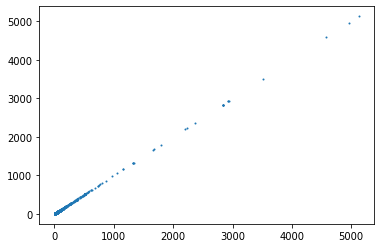

In [67]:
plt.scatter(
    estimator.estimated_central_moments['CD4 T cells']['second']/estimator.estimated_central_moments['CD4 T cells']['first']**2,
    np.exp(lognormal_params[1, :]),
    s=1
    )

In [65]:
stats.linregress(
    np.log(estimator.estimated_central_moments['CD4 T cells']['first'])[mask],
    np.log(estimator.estimated_central_moments['CD4 T cells']['second'])[mask]
)

LinregressResult(slope=1.2773909564458263, intercept=1.7328783244294268, rvalue=0.8923104992372801, pvalue=0.0, stderr=0.014653147205705932)

In [28]:
estimated_mean, estimated_var = estimator.estimated_central_moments['CD4 T cells']['first'], estimator.estimated_central_moments['CD4 T cells']['second']
#idx =~np.isnan(estimated_mean) & ~np.isnan(estimated_var)
idx = (estimated_mean < 2) & (estimated_var < 20)


In [30]:
(estimated_mean[idx] > estimated_var[idx]).mean()

0.17116182572614108

In [29]:
stats.linregress(estimated_mean[idx], estimated_var[idx])

LinregressResult(slope=5.4112905219071985, intercept=-0.030773465613060935, rvalue=0.7321548294267906, pvalue=2e-323, stderr=0.11471099393187344)

In [29]:
first = estimator.estimated_moments['CD4 T cells']['first']
second = estimator.estimated_moments['CD4 T cells']['second']

In [30]:
lognormal_conv_mat = np.array([[1, 1/2], [2, 2]])

In [32]:
lognormal_params = np.linalg.inv(lognormal_conv_mat).dot(np.log(np.vstack([first, second])))


In [61]:
raw_variance = estimator.observed_moments['CD4 T cells']['second'] - estimator.observed_moments['CD4 T cells']['first']**2
raw_mean = estimator.observed_moments['CD4 T cells']['first']

nb_dispersion_raw =  (raw_variance - raw_mean)/ raw_mean**2



In [60]:
nb_dispersion = (estimator.estimated_central_moments['CD4 T cells']['second'] - first) / first**2 

In [63]:
nb_dispersion[:5]

array([13.21003362, 36.28906663,  8.0954818 ,  9.0676278 ,  4.66750518])

In [65]:
nb_dispersion_raw[:5]

array([13.17944095, 36.2469149 ,  8.08507554,  9.05731705,  4.66054463])

(0, 10)

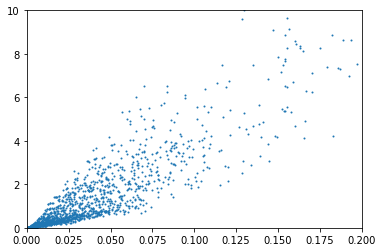

In [70]:
plt.scatter(raw_variance, estimated_var, s=1);
plt.xlim(0, 0.2);
plt.ylim(0, 10)

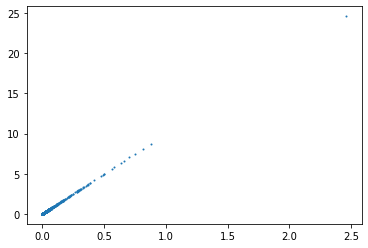

In [71]:
plt.scatter(raw_mean, first, s=1)

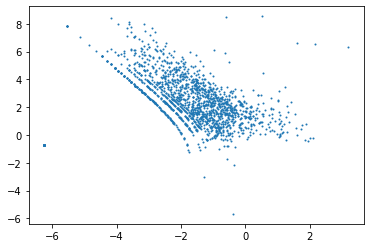

In [62]:
plt.scatter(
    np.log(first),
    np.log(nb_dispersion),
    s=1)

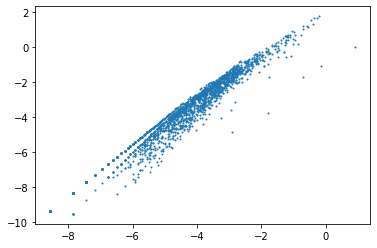

In [77]:
plt.scatter(np.log(raw_mean), lognormal_params[0, :], s=1)

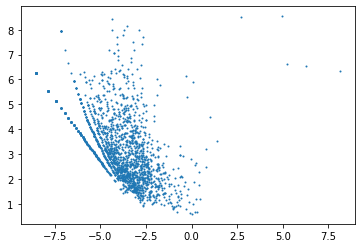

In [78]:
plt.scatter(np.log(raw_variance), lognormal_params[1, :], s=1)

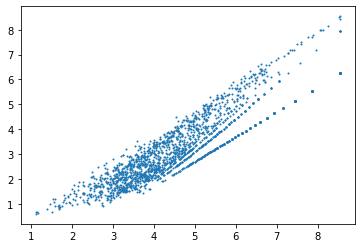

In [82]:
plt.scatter(raw_lognormal_params[1, :], lognormal_params[1, :], s=1)

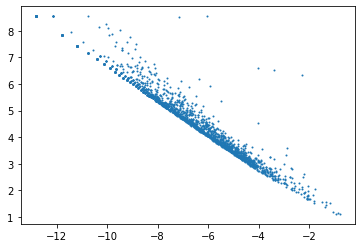

In [80]:
plt.scatter(
    raw_lognormal_params[0, :],
    raw_lognormal_params[1, :],
    s=1)

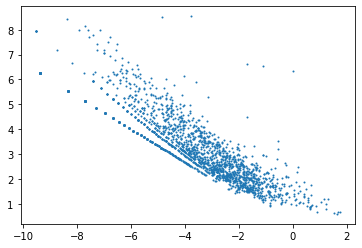

In [35]:
plt.scatter(
    lognormal_params[0, :],
    lognormal_params[1, :],
    s=1)

In [46]:
idx = ~np.isnan(first) & ~np.isnan(nb_dispersion)

In [47]:
stats.pearsonr(first[idx], nb_dispersion[idx])

(0.031104509007862206, 0.1700847688181194)

In [48]:
nb_dispersion = \
    (estimator.estimated_central_moments['CD4 T cells']['second'] - first) / first**2




In [55]:
raw_variance = estimator.observed_moments['CD4 T cells']['second'] - estimator.observed_moments['CD4 T cells']['first']**2
raw_mean = estimator.observed_moments['CD4 T cells']['first']

nb_dispersion_raw =  (raw_variance - raw_mean)/ raw_mean**2



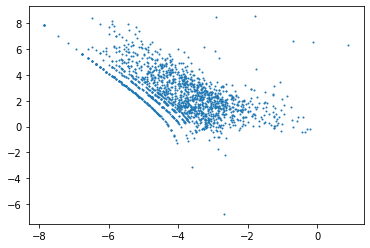

In [56]:
plt.scatter(
    np.log(raw_mean),
    np.log(nb_dispersion_raw),
    s=1);
# plt.xlim(0, 0.1);
# plt.ylim(0, 2)

In [186]:
((1/nb_dispersion) < 0.1).mean()

0.5751503006012024

(0, 2)

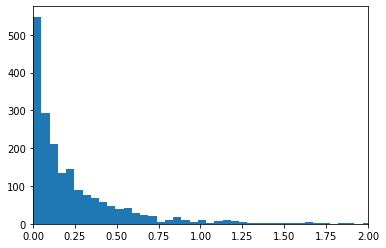

In [179]:
plt.hist(first, bins=500);
plt.xlim(0, 2)

In [176]:
(first > 0.1).mean()

0.5726452905811623

In [100]:
inv_gauss_shape = first**3 / estimator.estimated_central_moments['CD4 T cells']['second']

(0, 0.5)

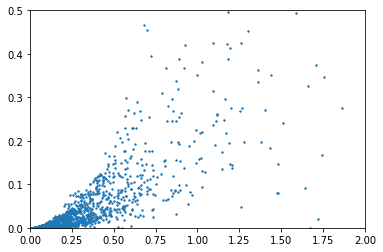

In [101]:
plt.scatter(
    first,
    inv_gauss_shape,
    s=2)
plt.xlim(0, 2)
plt.ylim(0, 0.5)

In [51]:
adata_ctrl.obs['n_counts'].values[temp]

array([ 703., 1869.,  817., ..., 1810.,  979., 1411.], dtype=float32)

### Cell type marker genes

In [22]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [52]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata_ctrl, 
    p=0.1, 
    num_permute=5,
    group_label='cell_type')

TypeError: __init__() got an unexpected keyword argument 'num_permute'

In [24]:
cell_type_stats = {}
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_statistics(group=ct)
    estimator.compute_observed_statistics(group=('-' + ct))
    
    estimator.compute_params(group=ct)
    estimator.compute_params(group=('-' + ct))

    estimator.compute_permuted_statistics(group=ct)
    estimator.compute_permuted_statistics(group=('-' + ct))
    
    t_stats, null_t_stats, pvals = estimator.differential_expression(ct, ('-' + ct), method='perm')
    cell_type_stats[ct] = {
        't_stat':t_stats,
        'null_t_stats':null_t_stats,
        'pvals': pvals
    }

Calculating stats for CD14+ Monocytes - ctrl
Calculating stats for CD4 T cells - ctrl
Calculating stats for Dendritic cells - ctrl
Calculating stats for NK cells - ctrl
Calculating stats for CD8 T cells - ctrl
Calculating stats for B cells - ctrl
Calculating stats for Megakaryocytes - ctrl
Calculating stats for FCGR3A+ Monocytes - ctrl


In [25]:
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print(
        '{} markers:'.format(ct), 
        adata_ctrl.var.index[
            np.argsort(cell_type_stats[ct]['t_stat'])[::-1][np.where(np.isnan(cell_type_stats[ct]['t_stat']))[0].shape[0]:][:75]].tolist())
    fdr = np.full_like(cell_type_stats[ct]['t_stat'], np.nan)
    _, fdr[~np.isnan(cell_type_stats[ct]['pvals'])] = \
        fdrcorrection(cell_type_stats[ct]['pvals'][~np.isnan(cell_type_stats[ct]['pvals'])])
    print('Number of sig. at 0.01 FDR:', (fdr < 0.01).sum())
    print()

CD14+ Monocytes - ctrl markers: ['S100A8', 'S100A9', 'CLEC5A', 'CLEC4E', 'TYROBP', 'FTL', 'MGST1', 'CCL2', 'PLA2G7', 'S100A12', 'CD63', 'IL8', 'IER3', 'HPSE', 'LGALS1', 'ANPEP', 'C15orf48', 'FCER1G', 'VCAN', 'CTB-61M7.2', 'FCN1', 'LHFPL2', 'TREM1', 'FNDC3B', 'CD14', 'CTSB', 'THBS1', 'TGFBI', 'LACC1', 'ANXA5', 'SLC7A11', 'CD300E', 'OLR1', 'C5AR1', 'CYP27A1', 'TYMP', 'S100A10', 'GRN', 'PDLIM7', 'ENG', 'PID1', 'DUSP6', 'S100A4', 'GPR84', 'SERPINB2', 'S100A6', 'CCR1', 'MAFB', 'S100A11', 'GPX1', 'ATP6V0B', 'RAC1', 'NCF2', 'PLAUR', 'LILRB4', 'SPI1', 'RAB13', 'SPHK1', 'CD68', 'CCL7', 'MARCKSL1', 'C19orf59', 'TIMP1', 'LGALS2', 'PVRL2', 'SIRPA', 'ANXA2', 'KYNU', 'FTH1', 'FPR3', 'PSAP', 'CXCL2', 'FCGRT', 'LGALS3', 'LIMS1']
Number of sig. at 0.01 FDR: 1070

CD4 T cells - ctrl markers: ['LEF1', 'TSHZ2', 'PASK', 'LTB', 'ADTRP', 'AQP3', 'CD3E', 'TRAT1', 'CD27', 'IL7R', 'NELL2', 'CD3G', 'CD3D', 'TNFRSF25', 'LCK', 'TMEM204', 'AES', 'SPOCK2', 'CD6', 'KLF2', 'PIK3IP1', 'ICOS', 'TMEM173', 'CCNG1', 'SFXN1

### Mean-variance in normalized scRNA seq

In [78]:
adata_norm = adata.copy()

In [79]:
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1e4)


In [80]:
sc.pp.log1p(adata_norm)


In [81]:
sc.pp.scale(adata_norm, max_value=10)


In [82]:
adata_cd4 = adata[adata.obs.cell_type == 'CD4 T cells - stim'].copy()

In [83]:
raw_mean = adata_cd4.X.mean(axis=0).A1
raw_var = (adata_cd4.X.toarray()**2).mean(axis=0)

In [84]:
mean = adata_norm.X.mean(axis=0)
var = adata_norm.X.var(axis=0)

In [85]:
(raw_mean == raw_var)

array([False, False, False, ..., False, False, False])

Text(0.5, 1.0, 'Observed variance')

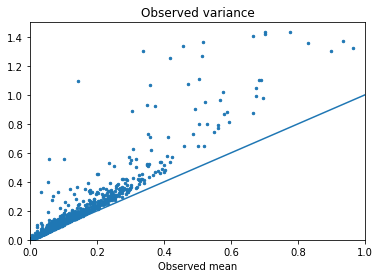

In [86]:
plt.scatter(raw_mean, adata_cd4.X.toarray().var(axis=0), s=6)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1);
plt.ylim(0, 1.5)
plt.xlabel('Observed mean');
plt.title('Observed variance')

### Study the mean-variance relationship

In [16]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [61]:
estimator = simplesc.SingleCellEstimator(
    adata, 
    p=0.15, 
    group_label='cell_type')

In [62]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD4 T cells - stim')
estimator.compute_observed_statistics(group='CD14+ Monocytes - ctrl')

In [63]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD4 T cells - stim')
estimator.compute_params(group='CD14+ Monocytes - ctrl')

In [65]:
# ctrl_means_raw = estimator.estimated_mean['CD14+ Monocytes - stim']
# ctrl_var_raw = np.diag(estimator.estimated_cov['CD14+ Monocytes - stim'])

# ctrl_means = ctrl_means_raw[~np.isnan(ctrl_means_raw) & ~np.isnan(ctrl_var_raw)]
# ctrl_var = ctrl_var_raw[~np.isnan(ctrl_means_raw) & ~np.isnan(ctrl_var_raw)]



In [66]:
ctrl_means_raw = estimator.estimated_mean['CD4 T cells - ctrl']
ctrl_var_raw = np.diag(estimator.estimated_cov['CD4 T cells - ctrl'])

ctrl_means = ctrl_means_raw[~np.isnan(ctrl_means_raw) & ~np.isnan(ctrl_var_raw)]
ctrl_var = ctrl_var_raw[~np.isnan(ctrl_means_raw) & ~np.isnan(ctrl_var_raw)]



In [67]:
stats.linregress(ctrl_means, np.sqrt(ctrl_var))

LinregressResult(slope=-0.16738559137297074, intercept=1.0858809439276562, rvalue=-0.9251354492133131, pvalue=0.0, stderr=0.0016945825262258082)

In [96]:
means_raw = estimator.estimated_mean['CD14+ Monocytes - ctrl']
var_raw = np.diag(estimator.estimated_cov['CD14+ Monocytes - ctrl'])

means = means_raw[~np.isnan(means_raw) & ~np.isnan(var_raw)]
var = var_raw[~np.isnan(means_raw) & ~np.isnan(var_raw)]

In [97]:
means.shape

(1653,)

In [98]:
var.shape

(1653,)

In [99]:
stats.linregress(means, np.sqrt(var))

LinregressResult(slope=-0.1731666433883422, intercept=1.097139563045578, rvalue=-0.8956197759428383, pvalue=0.0, stderr=0.0021166631809886403)

In [100]:
slope, intercept, r, p, _ = stats.linregress(means, np.sqrt(var))

In [101]:
res = (np.sqrt(var) - (means*slope + intercept))

In [102]:
adjusted_sigma = res + intercept

In [103]:
adjusted_var = adjusted_sigma**2

In [104]:
means.reshape(-1, 1).shape

(1653, 1)

In [105]:
np.sqrt(var).reshape(-1, 1).shape

(1653, 1)

In [106]:
param_matrix = np.hstack([means.reshape(-1, 1), np.sqrt(var).reshape(-1, 1)])

In [108]:
np.mean(param_matrix, axis=0)

array([-1.22026592,  1.30844892])

In [109]:
np.cov(param_matrix.T)

array([[ 3.76735706, -0.65238058],
       [-0.65238058,  0.14083737]])

In [87]:
stats.multivariate_normal.fit()

AttributeError: 'multivariate_normal_gen' object has no attribute 'fit'

In [110]:
stats.pearsonr(means, np.sqrt(var))

(-0.8956197759428381, 0.0)

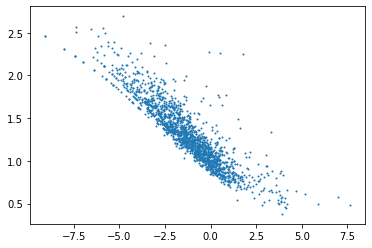

In [74]:
plt.scatter(means, np.sqrt(var), s=1)

Text(0, 0.5, 'Residual variance')

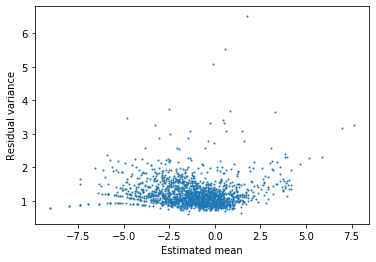

In [75]:
plt.scatter(means, adjusted_var, s=1) 
plt.xlabel('Estimated mean'); plt.ylabel('Residual variance')

In [76]:
plt.scatter(
    estimator.estimated_mean['CD4 T cells - stim'][(raw_mean == raw_var)],
    np.sqrt(np.diag(estimator.estimated_cov['CD4 T cells - stim']))[(raw_mean == raw_var)],
    s=5
)
plt.xlabel('Mean');
plt.ylabel('Variance')
plt.title('Mean - variance dependence')

NameError: name 'raw_mean' is not defined

In [62]:
estimator.estimated_mean['CD4 T cells - stim'][15]

-0.23731052347067705

In [63]:
estimator.estimated_cov['CD4 T cells - stim'][15, 15]

1.0382868498422868

(0, 1000)

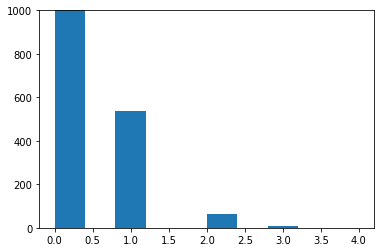

In [64]:
plt.hist(adata_cd4.X[:, 15].toarray());
plt.ylim(0, 1000)

In [106]:
def get_expression(adata, group_name, group, gene):
    
    cell_selector = (adata.obs[group_name] == group).values
    
    gene_selector = np.where(adata.var.index == gene)[0][0]
    
    return adata.X[cell_selector, gene_selector].toarray().reshape(-1)
    
    
def plot_histogram(adata, group_name, group_1, group_2, gene):
    
    expr_1 = get_expression(adata, group_name, group_1, gene)
    expr_2 = get_expression(adata, group_name, group_2, gene)
                            
    plt.hist(
        [
            expr_1,
            expr_2]
        , bins=50)

    
def naive_estimation(observed, p_hat=0.05, use='normal'):
    
    if use == 'normal':
        
        mu_hat = observed.mean() / p_hat
        
        sigma_hat = (observed.var() - observed.mean()*(1-p_hat))/p_hat**2
    
    else:
    
        mu_hat = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)

        sigma_hat = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))

    return mu_hat, sigma_hat


def generalized_binom_coef(x,y):

    return sp.special.gamma(x+1) / (sp.special.gamma(y+1) * sp.special.gamma(x-y+1))


class toy_rv(stats.rv_discrete):
    
    def _pmf(self, k, n, p):
        
        return generalized_binom_coef(n, k) * p ** (k) * (1-p)**(n-k)

    
def simulate(m, s, num_cells=2000, p=0.05, use='normal'):
    
    if use == 'normal':
        
        continuous_data = stats.norm.rvs(
            loc=m,
            scale=s,
            size=num_cells)
    else:    
    
        continuous_data = stats.lognorm.rvs(
            s=s, 
            scale=np.exp(m), 
            size=num_cells)
        
    data = \
        toy_rv().rvs(
            n=np.maximum(continuous_data, 0.001),
            p=p)
    return data


def generate_moment_mat(size=2):
    
    B = np.zeros((size, 2))
    B[:, 0] = np.arange(size)+1
    B[:, 1] = (np.arange(size)+1)**2/2
    return B


def get_observed_moments(data, order=2):
    
    first = data.mean()
    
    second_sum = (data**2).sum()
    
    if data.max() == 1:
        
        second_sum += 2
    
    second = second_sum / data.shape[0]
    
    third = (data**3).mean()
    
    if order == 2:
        
        return np.array([first, second])
    else:
        return np.array([first, second, third])


def linsys_estimation(data, p=0.1, order=2, lam_max=3):
    
    if order == 3:
        A = np.zeros((3,3))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        A[2, 0] = (2*p**3 - 3*p**2 + p)
        A[2, 1] = (3*p**2 - 3*p**3)
        A[2, 2] = p**3
    else:
        A = np.zeros((2,2))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        
    #lam = (1-(data < 1).mean())
    lam = 0
    logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=order)))
    B = generate_moment_mat(size=order)
    #R = lam * np.array([1, 1]).reshape(1, -1)
    sol = np.linalg.inv(B.T.dot(B) + lam*np.eye(2)).dot(B.T).dot(logex)
    #sol = np.linalg.inv(B.T.dot(B)).dot(B.T.dot(logex) - R)
    return logex, sol[0, 0], np.sqrt(sol[1, 0])

Text(0.5, 1.0, 'Mean - variance dependence')

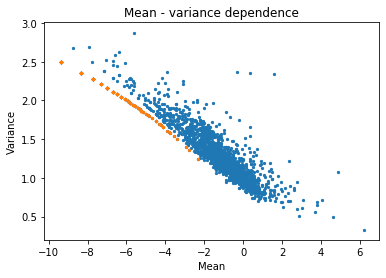

In [139]:
plt.scatter(
    estimator.estimated_mean['CD4 T cells - stim'],
    np.sqrt(np.diag(estimator.estimated_cov['CD4 T cells - stim'])),
    s=5
)

plt.scatter(
    estimator.estimated_mean['CD4 T cells - stim'][np.isclose(raw_mean, raw_var)],
    np.sqrt(np.diag(estimator.estimated_cov['CD4 T cells - stim']))[np.isclose(raw_mean, raw_var)],
    s=5
)
plt.xlabel('Mean');
plt.ylabel('Variance')
plt.title('Mean - variance dependence')

In [115]:
set(adata.var.index[np.isclose(raw_mean, raw_var)])

Index(['CLIC4', 'FGR', 'S100A12', 'RAB13', 'FCGR2A', 'FCGR3A', 'NCF2', 'RGL1',
       'KMO', 'QPCT',
       ...
       'LILRB2', 'LILRA3', 'LILRA5', 'LAIR1', 'LILRA2', 'LILRB1', 'LILRB4',
       'CECR1', 'HMOX1', 'LGALS2'],
      dtype='object', name='index', length=135)

In [107]:
raw_mean

array([0.03997703, 7.4797378 , 0.03882937, ..., 0.05260142, 0.00937261,
       0.25688353], dtype=float32)

In [116]:
set(adata.var.index[
    np.where(estimator.estimated_mean['CD4 T cells - stim'] < -5)[0]]) - set(adata.var.index[np.isclose(raw_mean, raw_var)])

{'ALCAM',
 'ANKRD22',
 'ATF3',
 'CCDC88A',
 'CD9',
 'CEBPD',
 'CLEC4E',
 'CTB-61M7.2',
 'CTSH',
 'CTSZ',
 'CYP1B1',
 'FAM49A',
 'FGFBP2',
 'G0S2',
 'GPR35',
 'GZMH',
 'HBG2',
 'ICAM1',
 'IGLL5',
 'IRG1',
 'KLRC1',
 'LAT2',
 'MARCKS',
 'MPP1',
 'MS4A1',
 'MS4A6A',
 'MSC',
 'MTMR11',
 'MTSS1',
 'OSM',
 'PSTPIP2',
 'RNASE6',
 'RXRA',
 'S100A8',
 'SDS',
 'SERPING1',
 'SPI1',
 'SWAP70',
 'TCL1A'}

In [133]:
p = 0.1
use = 'log'
gene = 'ICAM1'
# lowly_expressed = get_expression(
#     adata, 
#     'cell_type', 
#     'CD4 T cells - ctrl',
#     gene)

highly_expressed = get_expression(
    adata, 
    'cell_type', 
    'CD4 T cells - stim',
    gene)

#m1, s1 = naive_estimation(lowly_expressed, p_hat=p, use=use)
m2, s2 = naive_estimation(highly_expressed, p_hat=p, use=use)
print(m2, s2)

-5.976364844939072 2.2023695972813737


In [134]:
highly_expressed.mean()

0.002869166

In [135]:
(highly_expressed**2).mean()

0.003634277

(0, 100)

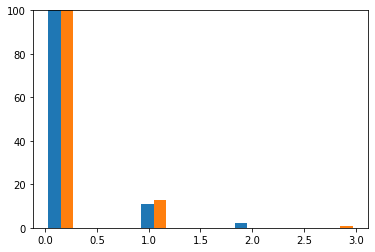

In [136]:
plt.hist(
    [
        highly_expressed, 
        simulate(m2, s2, highly_expressed.shape[0], p=p, use=use)
    ], bins=10);
# plt.xlim(0, 50);
plt.ylim(0, 100)

In [105]:
highly_expressed

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [95]:
new_data = np.concatenate([highly_expressed, np.array([2])])
m3, s3 = naive_estimation(new_data, p_hat=p, use=use)

In [102]:
np.log(highly_expressed.mean()/p) - s3**2/2

-6.174303229791375

In [97]:
m3

-6.007440427601294

In [98]:
s3

2.1508135873983805

In [368]:
cov_mat = estimator.estimated_cov['CD4 T cells - stim']

In [369]:
cov_mat.shape

(1654, 1654)

In [370]:
mu_matrix = estimator.estimated_mean['CD4 T cells - stim']\
    .reshape(-1, 1)\
    .dot(
        estimator.estimated_mean['CD4 T cells - stim'].reshape(1, -1))




In [392]:
var_matrix = np.diag(estimator.estimated_cov['CD4 T cells - stim'])\
    .reshape(-1, 1)\
    .dot(
        np.diag(estimator.estimated_cov['CD4 T cells - stim']).reshape(1, -1))




In [394]:
mu_vec_raw = mu_matrix.reshape(-1)
cov_vec_raw = (cov_mat / var_matrix).A1

mu_vec = mu_vec_raw[~np.isnan(mu_vec_raw) & ~np.isnan(cov_vec_raw)]

cov_vec = cov_vec_raw[~np.isnan(mu_vec_raw) & ~np.isnan(cov_vec_raw)]


In [395]:
idx = np.random.permutation(mu_vec.shape[0])[:10000]

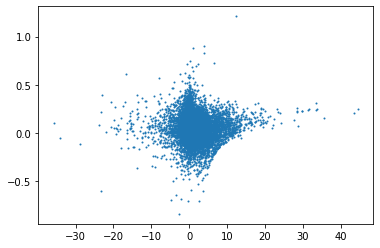

In [396]:
plt.scatter(mu_vec[idx], cov_vec[idx], s=1)

In [319]:
x, r, _, _ = np.linalg.lstsq(
    np.hstack([means.reshape(-1, 1), np.ones((means.shape[0], 1))]), 
    var.reshape(-1, 1))

In [321]:
r

array([400.30944093])

In [320]:
x

array([[-0.51930732],
       [ 1.16093706]])

### Effect of interferon stimulation

In [30]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [31]:
estimator = simplesc.SingleCellEstimator(
    adata, 
    p=0.05, 
    group_label='stim')

In [32]:
estimator.compute_observed_statistics(group='ctrl')
estimator.compute_observed_statistics(group='stim')

In [33]:
estimator.compute_params(group='ctrl')
estimator.compute_params(group='stim')

In [34]:
estimator.compute_permuted_statistics(group='ctrl')
estimator.compute_permuted_statistics(group='stim')


In [35]:
t_stats, null_t_stats, pvals = estimator.differential_expression('ctrl', 'stim', method='perm')


In [36]:
fdr = np.full_like(pvals, np.nan)
_, fdr[~np.isnan(pvals)] = fdrcorrection(pvals[~np.isnan(pvals)])


Text(0, 0.5, 'Count')

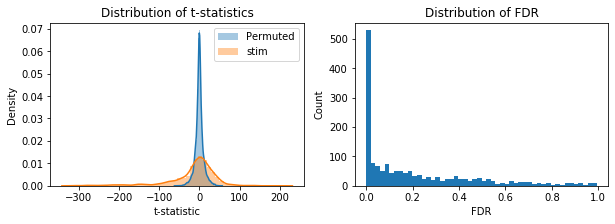

In [37]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(null_t_stats[~np.isnan(null_t_stats)]);
sns.distplot(t_stats[~np.isnan(t_stats)]);
plt.legend(['Permuted','stim']);
plt.xlabel('t-statistic');
plt.ylabel('Density');
plt.title('Distribution of t-statistics')
plt.subplot(1, 2, 2);
plt.hist(fdr[~np.isnan(fdr)], bins=50);
plt.title('Distribution of FDR')
plt.xlabel('FDR');
plt.ylabel('Count')

In [38]:
print('Number of significant genes at 0.01 FDR:', (fdr < 0.01).sum())

Number of significant genes at 0.01 FDR: 484


In [39]:
print('Upregulated genes: ', adata.var.index[np.argsort(t_stats)[:50]].tolist())

Upregulated genes:  ['CXCL11', 'CCL8', 'IFIT1', 'IFIT3', 'HESX1', 'TGM1', 'IFIT2', 'CMPK2', 'ISG15', 'RSAD2', 'CXCL10', 'IFI44L', 'ISG20', 'HERC5', 'IL27', 'DEFB1', 'LY6E', 'OAS3', 'TNFSF10', 'NEXN', 'MX2', 'IL1RN', 'NUPR1', 'NT5C3A', 'OAS2', 'DDX58', 'MT2A', 'IFITM3', 'TRIM22', 'HERC6', 'APOBEC3A', 'ETV7', 'RTP4', 'APOBEC3B', 'IFI35', 'GMPR', 'CD38', 'DHX58', 'SAMD9', 'SAMD4A', 'IRG1', 'SAMD9L', 'IFIH1', 'IDO1', 'HES4', 'PNPT1', 'SERPING1', 'IFIT5', 'ZBP1', 'SPATS2L']


In [40]:
print('Downregulated genes: ', adata.var.index[np.argsort(t_stats)[::-1][:50]].tolist())

Downregulated genes:  ['CLEC5A', 'VCAN', 'C19orf59', 'PID1', 'OSM', 'IL1B', 'IL8', 'CTB-61M7.2', 'CD14', 'CD9', 'CYP27A1', 'IER3', 'PLXDC2', 'QSOX1', 'S100A8', 'CXCL1', 'PHLDA1', 'SLC11A1', 'THBS1', 'FOS', 'GLTP', 'GAPT', 'MARCKSL1', 'AMICA1', 'LTA4H', 'ENG', 'GLIPR1', 'QPCT', 'EIF3L', 'LRRC25', 'INSIG1', 'CD79B', 'HNMT', 'PPIF', 'PNP', 'G0S2', 'CLTB', 'C10orf54', 'ACTN1', 'SLC7A11', 'ID3', 'FERMT3', 'CD27', 'GNA15', 'EPB41L3', 'PDLIM7', 'CD82', 'PRDX5', 'AC093673.5', 'UCP2']


### Compute the null distribution

In [131]:
adata_ctrl.obs['fake_cell_type'] = np.random.permutation(adata_ctrl.obs['cell_type'])

In [132]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(adata_ctrl, p=0.1, num_permute=3, group_label='fake_cell_type')

In [133]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD14+ Monocytes - ctrl')

In [134]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD14+ Monocytes - ctrl')

In [135]:
estimator.compute_permuted_statistics(group='CD4 T cells - ctrl')
estimator.compute_permuted_statistics(group='CD14+ Monocytes - ctrl')


In [136]:
t_statistic, null_t_statistic, pvals = estimator.differential_expression('CD4 T cells - ctrl', 'CD14+ Monocytes - ctrl', method='perm')

Text(0.5,1,'Distribution of p-values for shuffled labels')

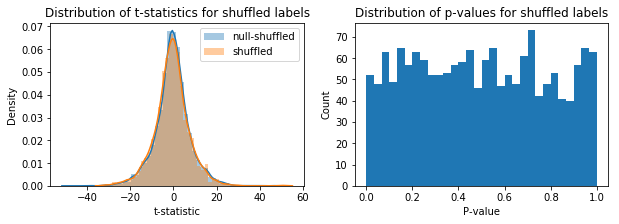

In [137]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(null_t_statistic[~np.isnan(null_t_statistic)], bins=50);
sns.distplot(t_statistic[~np.isnan(t_statistic)], bins=50);
plt.title('Distribution of t-statistics for shuffled labels');
plt.ylabel('Density'); plt.xlabel('t-statistic');
plt.legend(['null-shuffled', 'shuffled']);
plt.subplot(1, 2, 2);
plt.hist(pvals[~np.isnan(pvals)], bins=30);
plt.ylabel('Count');plt.xlabel('P-value');
plt.title('Distribution of p-values for shuffled labels')